# Analysis - exp68

- exp66 but using plain SGD.

In [1]:
import os
import csv
import numpy as np
import torch as th
import pandas as pd

from glob import glob
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from notebook_helpers import load_params
from notebook_helpers import load_monitored
from notebook_helpers import join_monitored
from notebook_helpers import score_summary

def load_data(path, model, run_index=None):
    runs = range(run_index[0], run_index[1]+1)
    exps = []
    for r in runs:
        file = os.path.join(path, f"run_{model}_{r}_monitor.csv".format(int(r)))
        try:
            mon = load_monitored(file)
        except FileNotFoundError:
            mon = None
        exps.append(mon)
    return exps

def load_hp(name):
    return pd.read_csv(name, index_col=False)

def find_best(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmax(scores)

    return hp[best:best+1]

def find_worst(hp, data, window, score="score"):
    scores = []
    for r, mon in enumerate(data):
        if mon is not None:
            full = mon[score]
            selected = full[window[0]:window[1]]
            x = np.mean(selected)
            scores.append(x)
        else:
            scores.append(np.nan)
    best = np.nanargmin(scores)
    return hp[best:best+1]

# Load data

In [5]:
path = "/Users/qualia/Code/azad/data/wythoff/exp68/"

hp = load_hp(os.path.join(path,"grid.csv"))

models = ["DQN_xy1", "DQN_xy2", "DQN_xy3", "DQN_xy4", "DQN_xy5"]
index = (0, 250)

In [6]:
hp[0:1]

,row_code,device_code,epsilon,gamma,learning_rate
0,0,0,0.1,0.1,0.0025


# Plots
## All parameter summary

How's it look overall.

### Timecourse

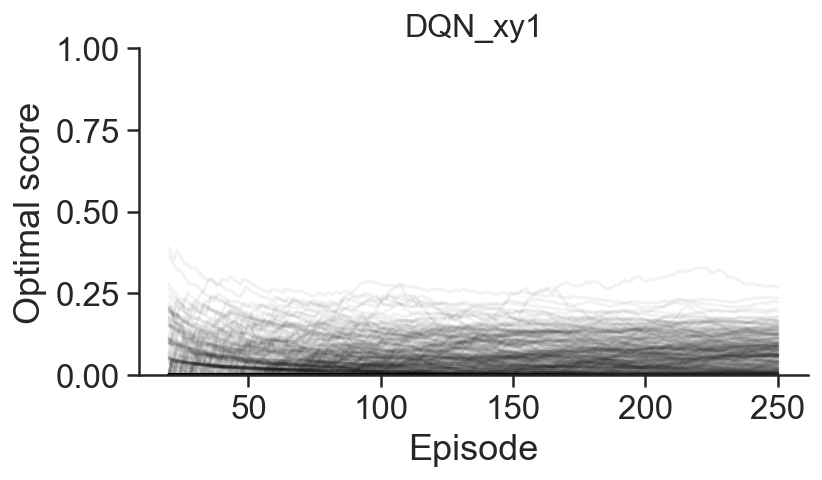

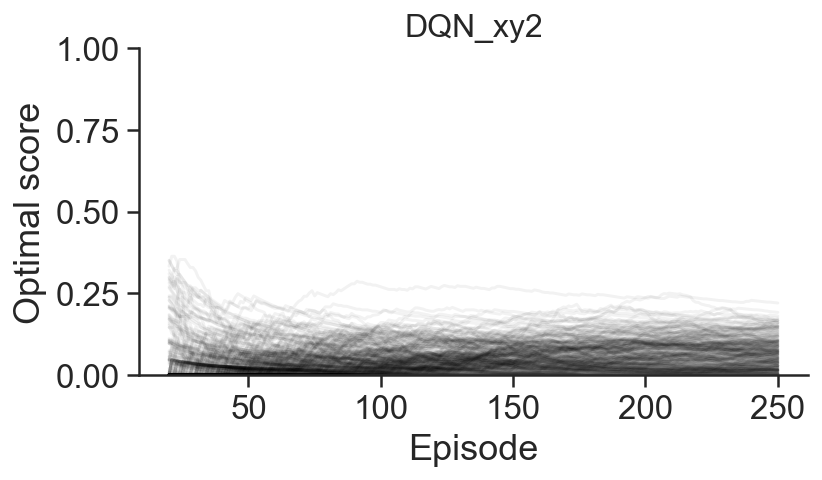

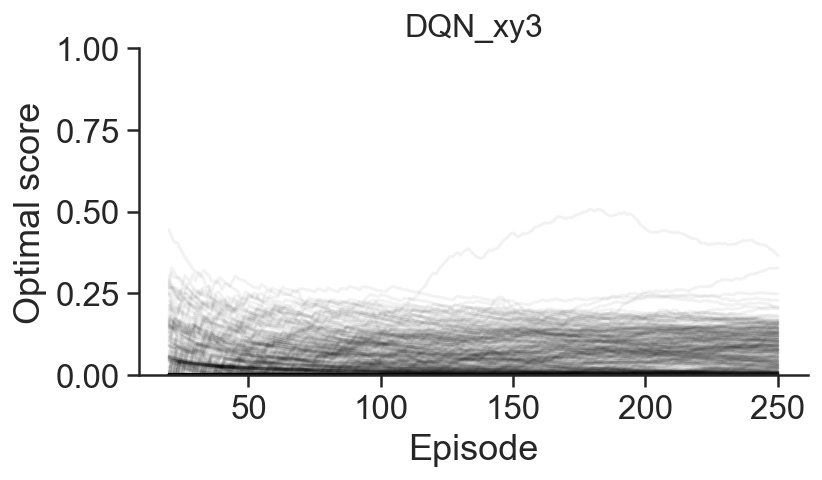

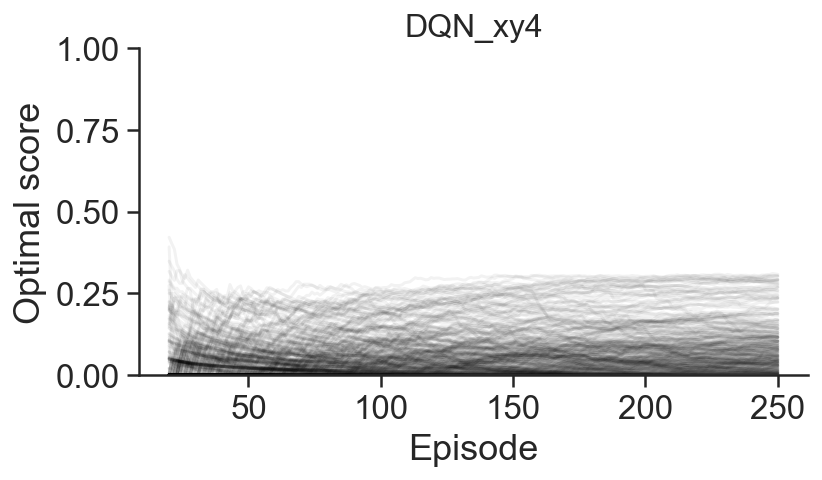

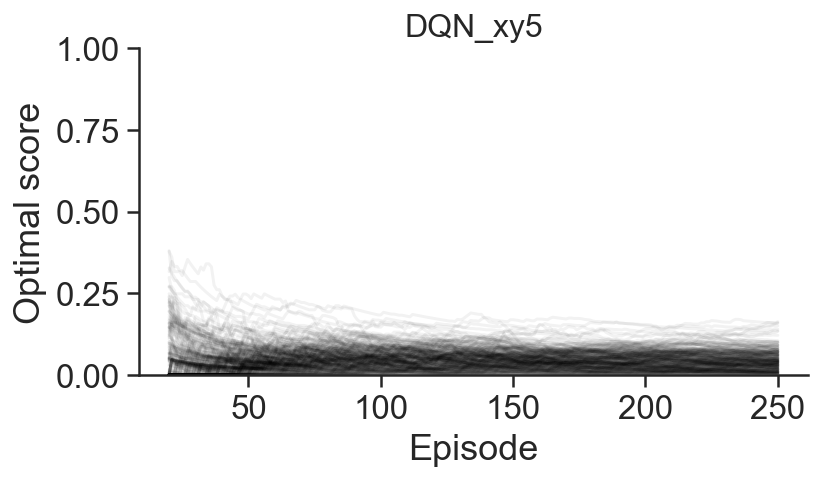

In [7]:
for model in models:
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    for r, mon in enumerate(data):
        if mon is not None:
            _ = plt.plot(mon['episode'], mon['score'], color='black', alpha=0.05)
            _ = plt.ylim(0, 1)
    _ = plt.title(model)
    _ = plt.ylabel("Optimal score")
    _ = plt.xlabel("Episode")
    sns.despine()

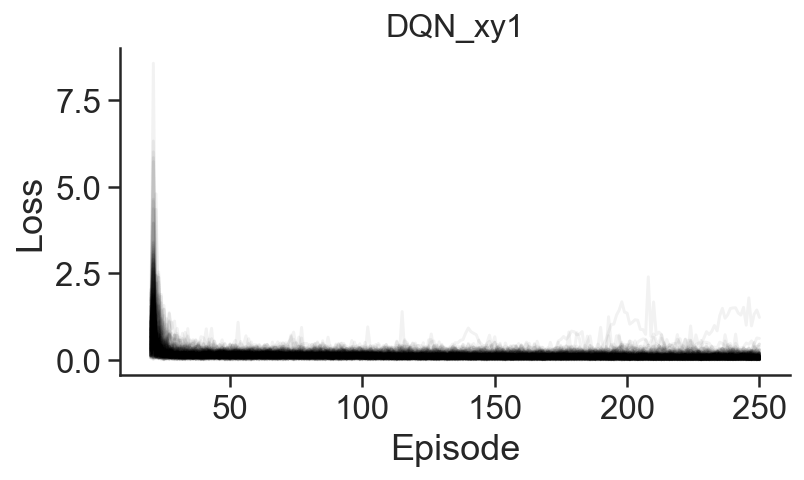

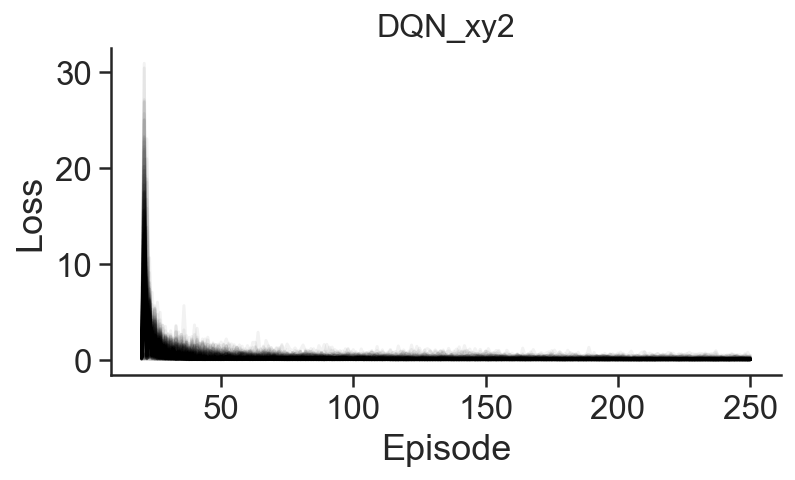

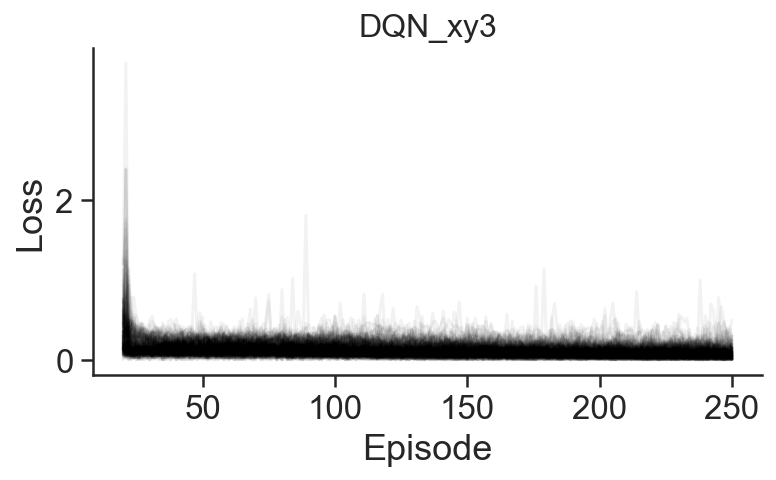

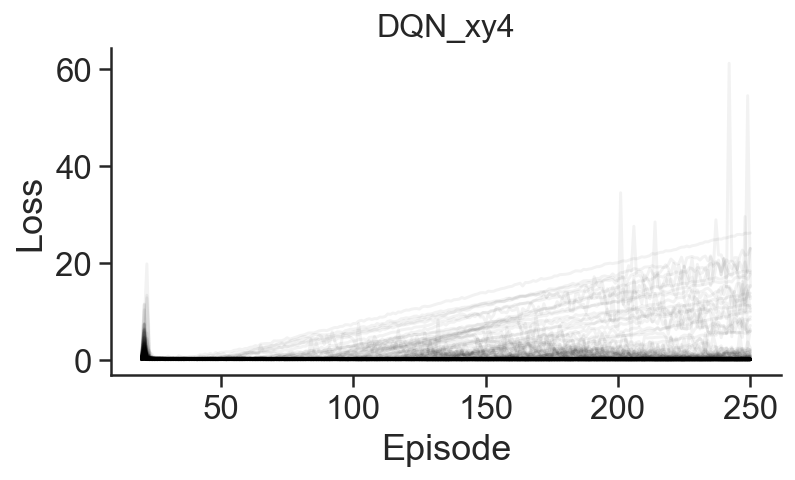

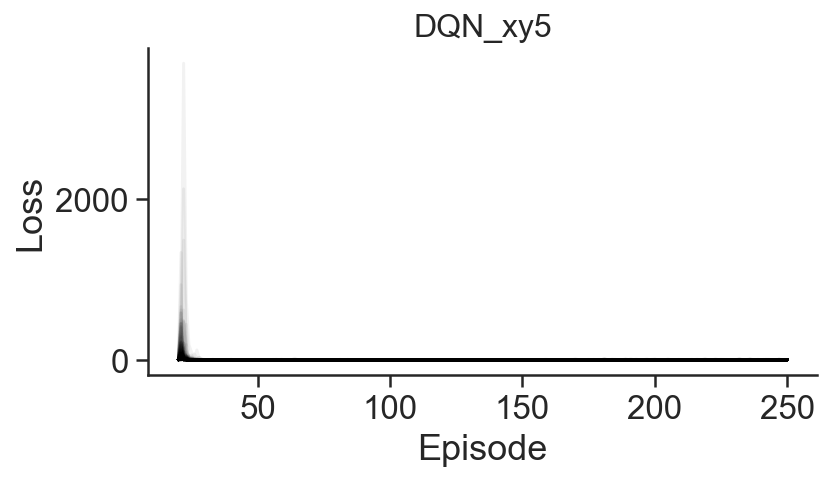

In [8]:
for model in models:
    data = load_data(path, model, run_index=index)
    plt.figure(figsize=(6, 3))
    for r, mon in enumerate(data):
        if mon is not None:
            _ = plt.plot(mon['episode'], mon['loss'], color='black', alpha=0.05)
#             _ = plt.ylim(0, 1)
    _ = plt.title(model)
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Episode")
    sns.despine()

## Plot loss dist

Want to split

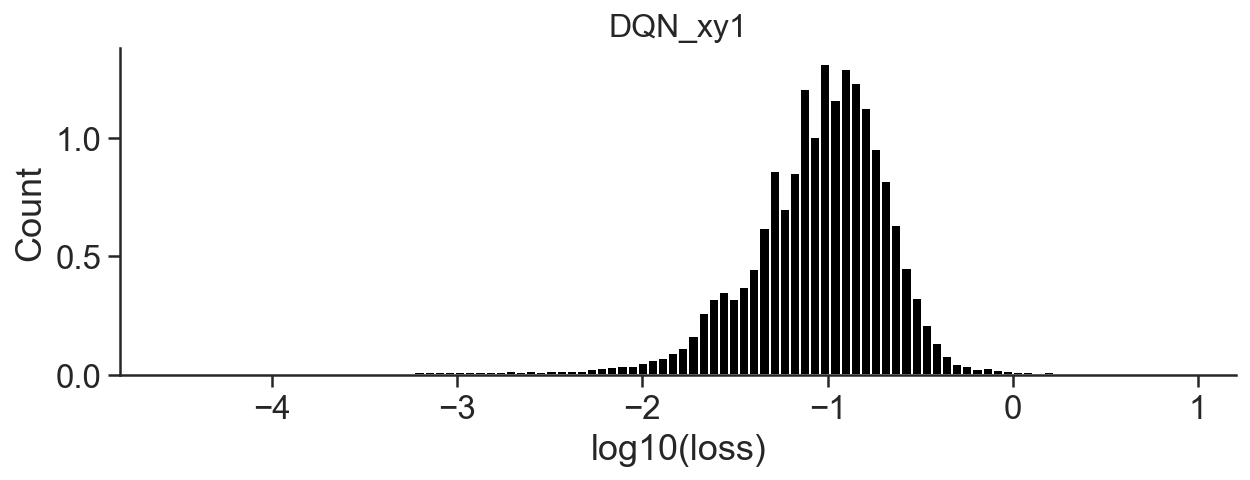

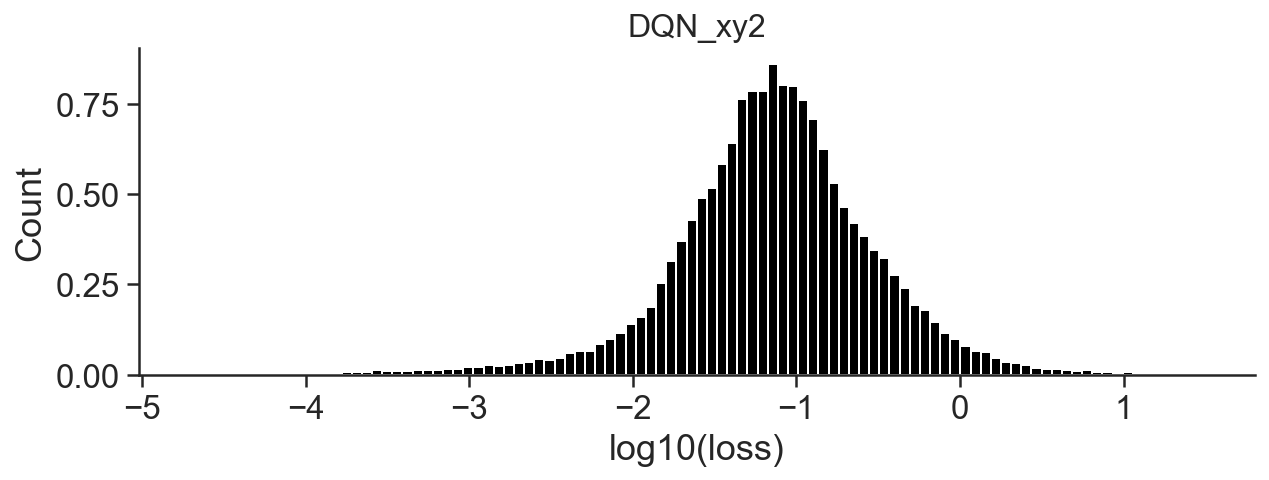

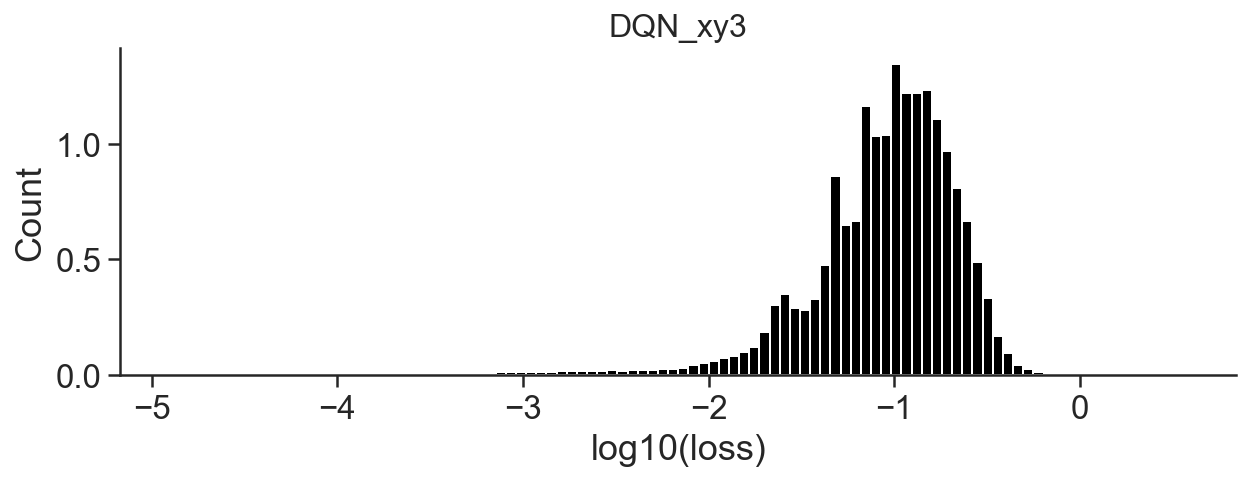

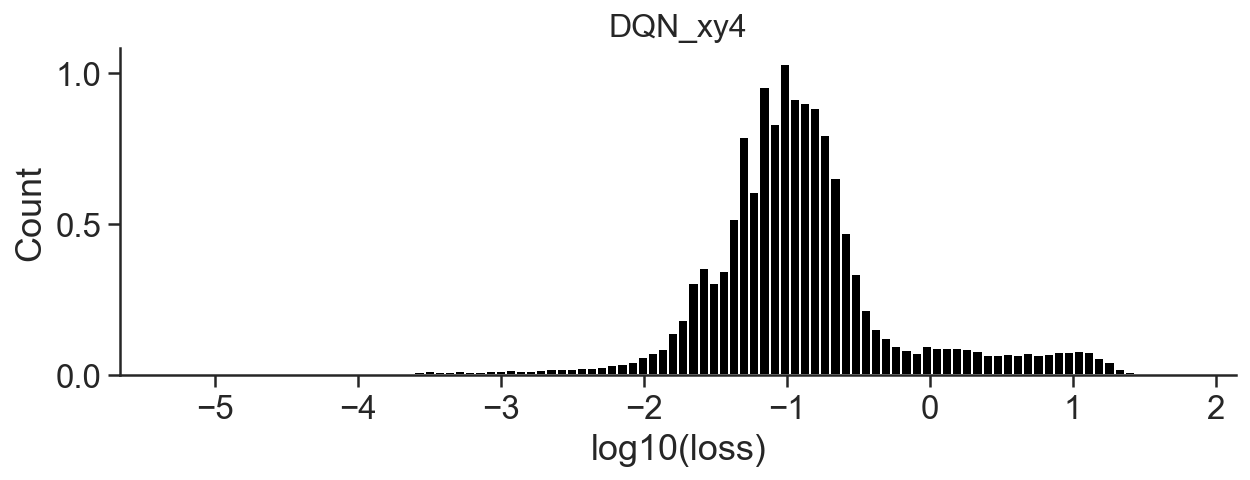

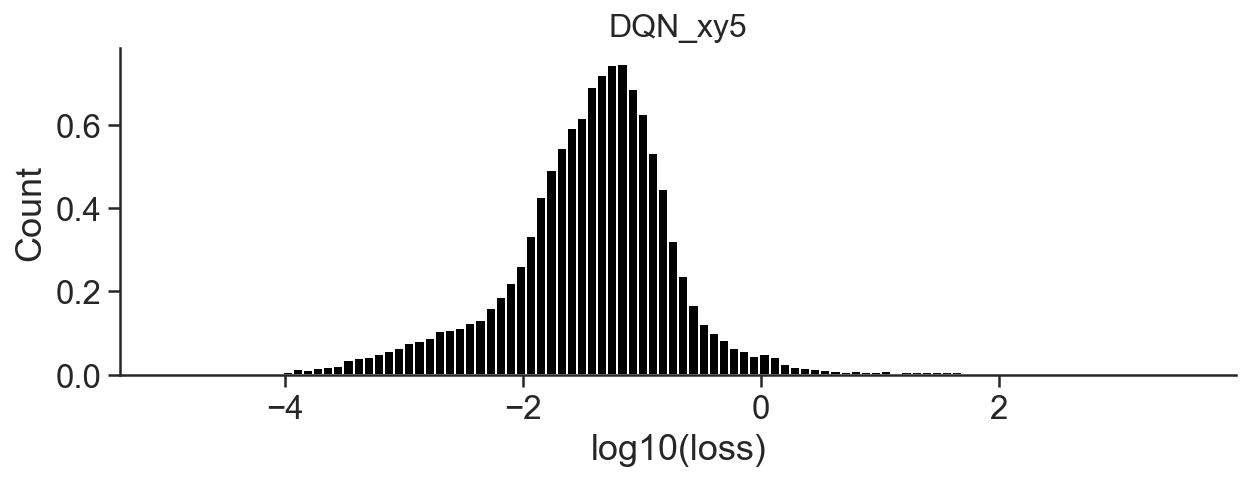

In [9]:
for model in models:
    losses = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            losses.extend(mon["loss"])
    
    plt.figure(figsize=(10, 3))
    _ = plt.hist(np.log10(losses), color='black', bins=100, density=True)
    _ = plt.title(model)
    _ = plt.ylabel("Count")
    _ = plt.xlabel("log10(loss)")
    sns.despine()

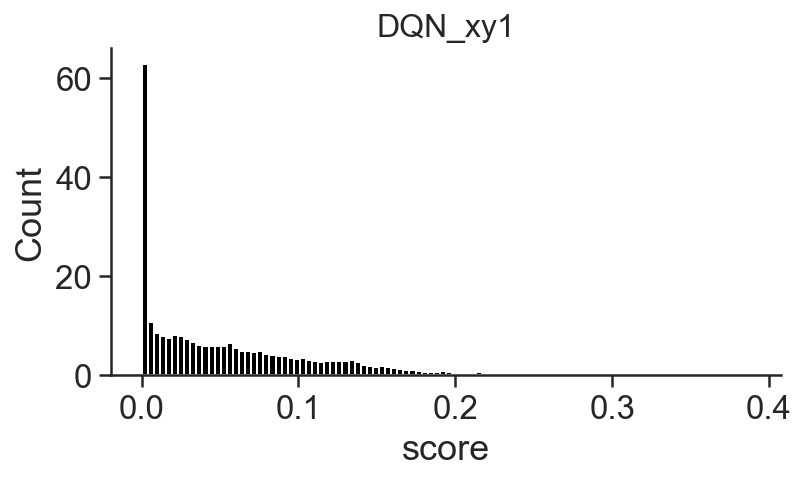

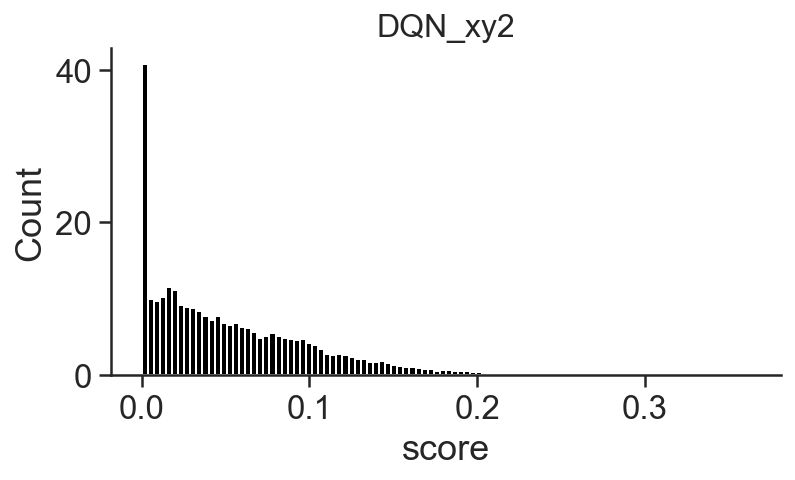

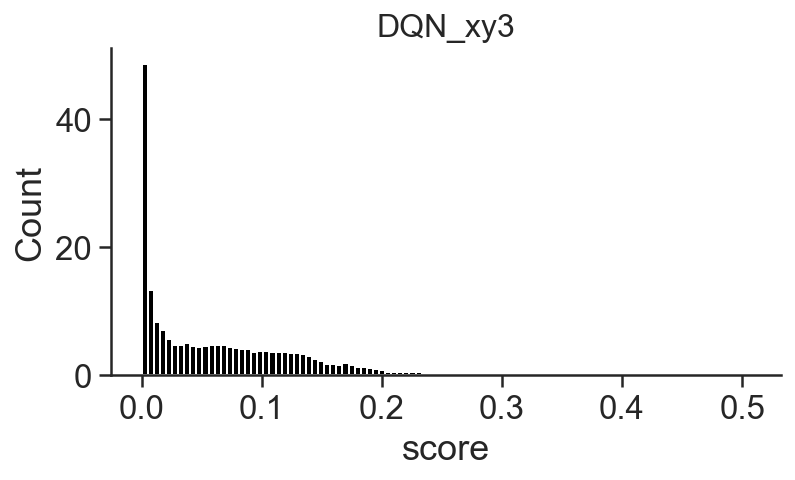

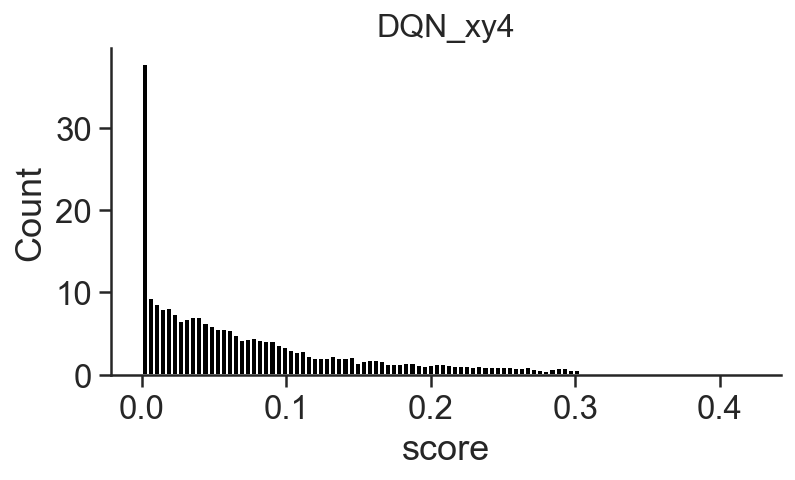

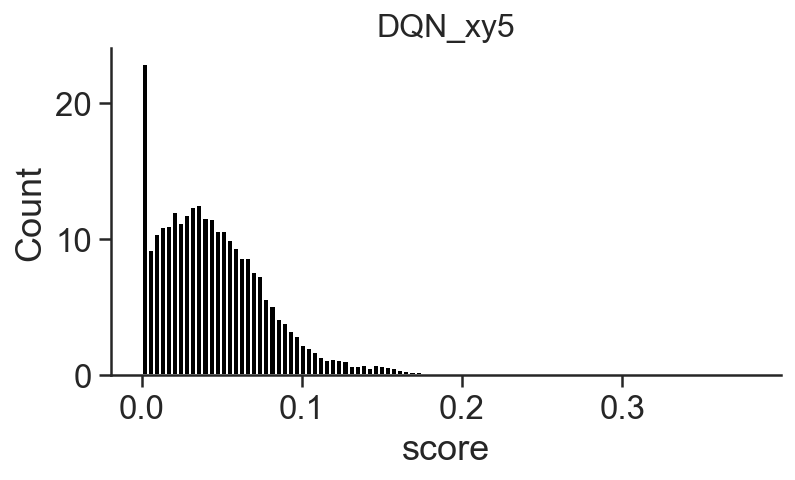

In [12]:
for model in models:
    scores = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            scores.extend(mon["score"])
    
    plt.figure(figsize=(6, 3))
    _ = plt.hist(scores, color='black', bins=100, density=True)
    _ = plt.title(model)
    _ = plt.ylabel("Count")
    _ = plt.xlabel("score")
    sns.despine()

## Plot log(loss) by score

At the final trial

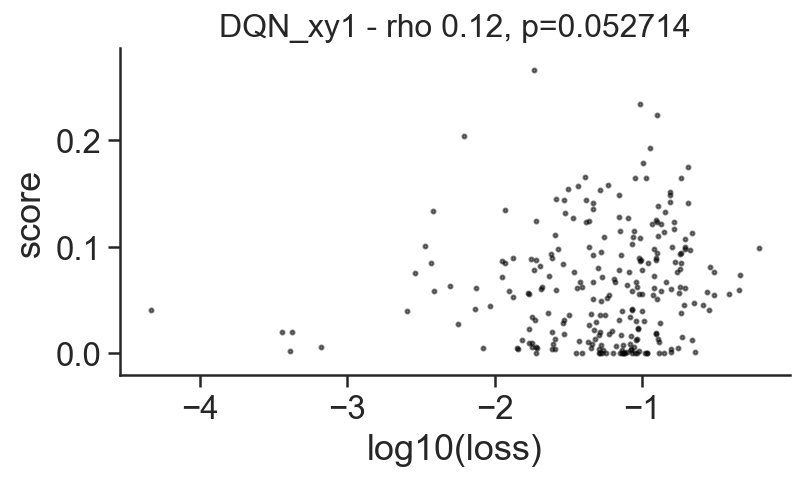

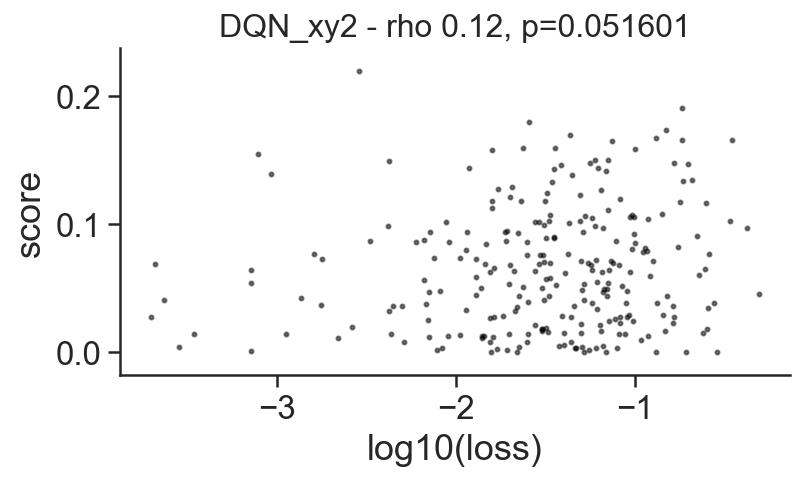

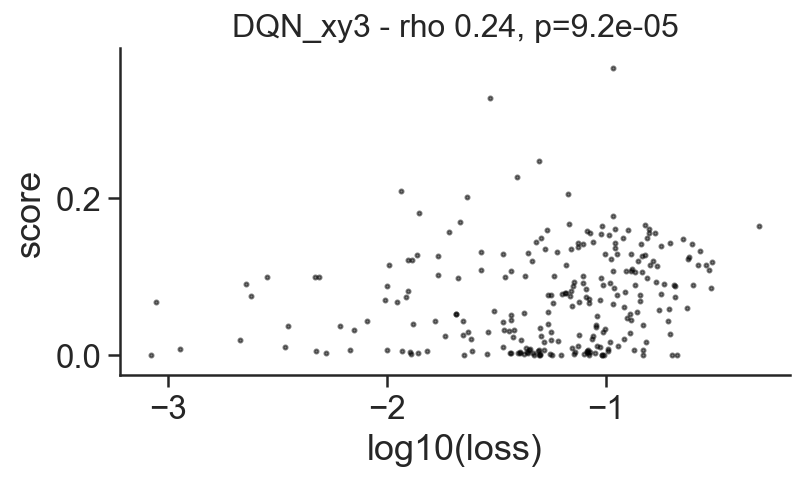

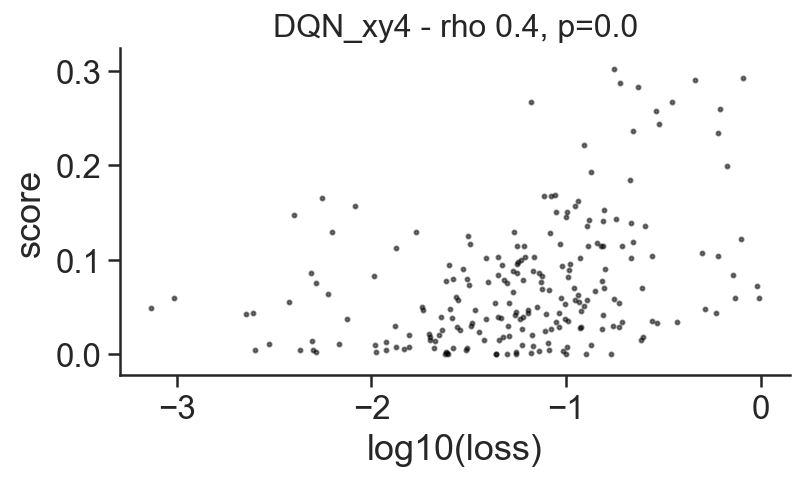

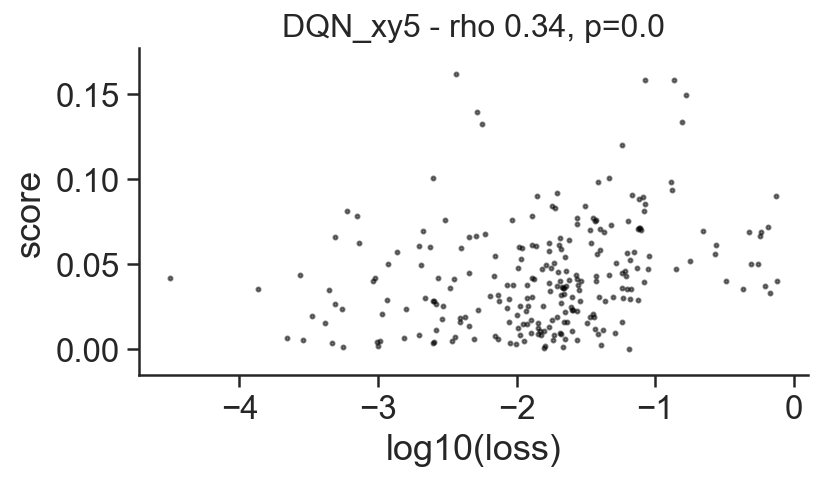

In [15]:
from scipy.stats import spearmanr

cutoff = 0
for model in models:
    losses = []
    scores = []
    data = load_data(path, model, run_index=index)
    for r, mon in enumerate(data):
        if mon is not None:
            loss = np.log10(mon["loss"][-1])
            if loss < cutoff:
                losses.append(loss)
                scores.append(mon["score"][-1])
            
    plt.figure(figsize=(6, 3))
    _ = plt.scatter(losses, scores, color='black', alpha=0.5, s=4)
    r, p = spearmanr(losses, scores)
    _ = plt.title(f"{model} - rho {np.round(r,2)}, p={np.round(p,6)}")
    _ = plt.xlabel("log10(loss)")
    _ = plt.ylabel("score")
    sns.despine()

# Find the best HP

## By score

In [17]:
for model in models:
    data = load_data(path, model, run_index=index)
    best_hp = find_best(hp, data, (200,250))
    print(f"{model}:\n{best_hp}\n---")

DQN_xy1:
     row_code  device_code  epsilon  gamma  learning_rate
189       189            1      0.1    0.4        0.19949
---
DQN_xy2:
    row_code  device_code  epsilon  gamma  learning_rate
25        25            1      0.1    0.1       0.128776
---
DQN_xy3:
     row_code  device_code  epsilon  gamma  learning_rate
155       155            3      0.1    0.4       0.027755
---
DQN_xy4:
    row_code  device_code  epsilon  gamma  learning_rate
85        85            1      0.1    0.2       0.179286
---
DQN_xy5:
    row_code  device_code  epsilon  gamma  learning_rate
35        35            3      0.1    0.1       0.179286
---


## By loss

In [18]:
for model in models:
    data = load_data(path, model, run_index=index)
    best_hp = find_worst(hp, data, (200,250), score='loss')
    print(f"{model}:\n{best_hp}\n---")

DQN_xy1:
     row_code  device_code  epsilon  gamma  learning_rate
190       190            2      0.1    0.4       0.204541
---
DQN_xy2:
     row_code  device_code  epsilon  gamma  learning_rate
246       246            2      0.1    0.5       0.234847
---
DQN_xy3:
     row_code  device_code  epsilon  gamma  learning_rate
246       246            2      0.1    0.5       0.234847
---
DQN_xy4:
     row_code  device_code  epsilon  gamma  learning_rate
172       172            0      0.1    0.4       0.113622
---
DQN_xy5:
     row_code  device_code  epsilon  gamma  learning_rate
241       241            1      0.1    0.5       0.209592
---


# Plot best

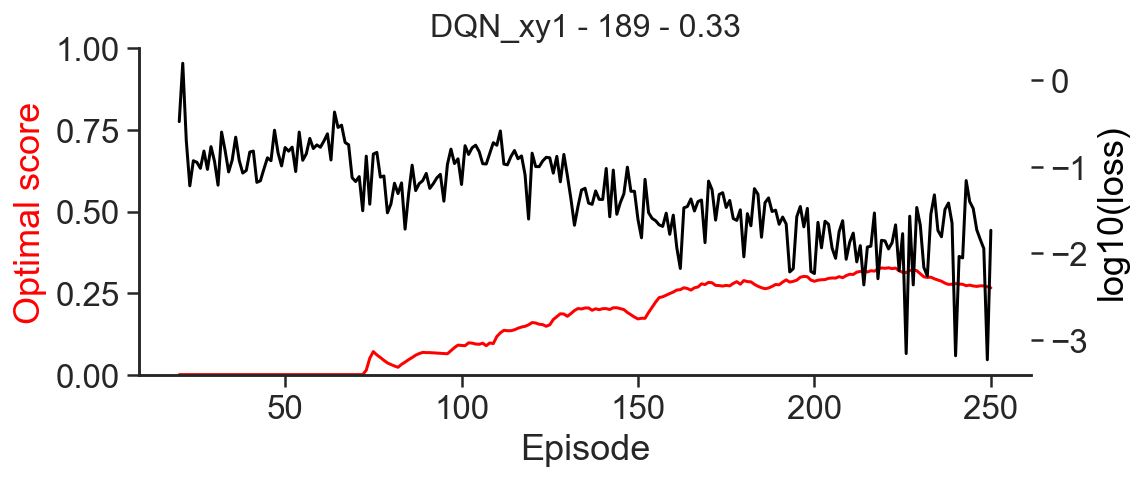

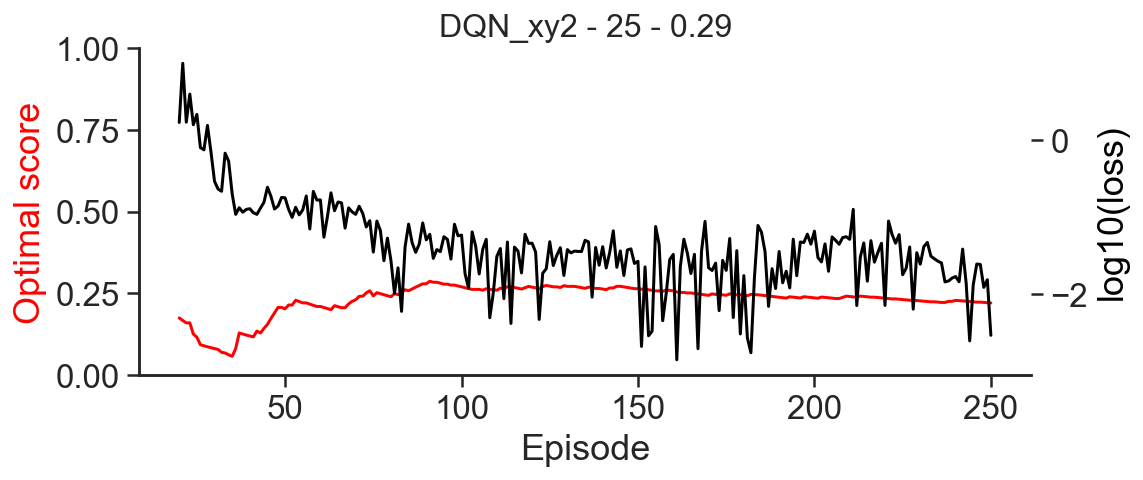

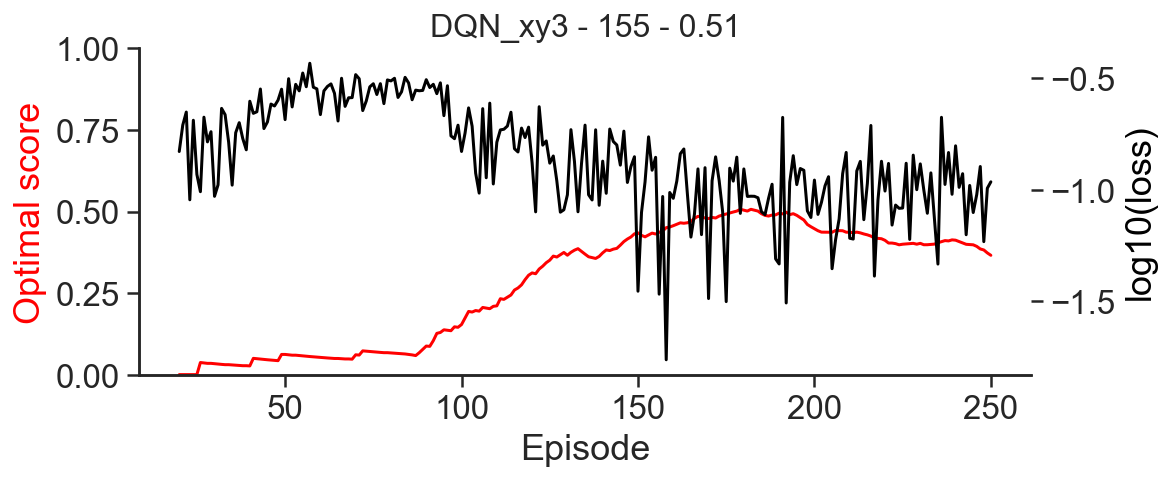

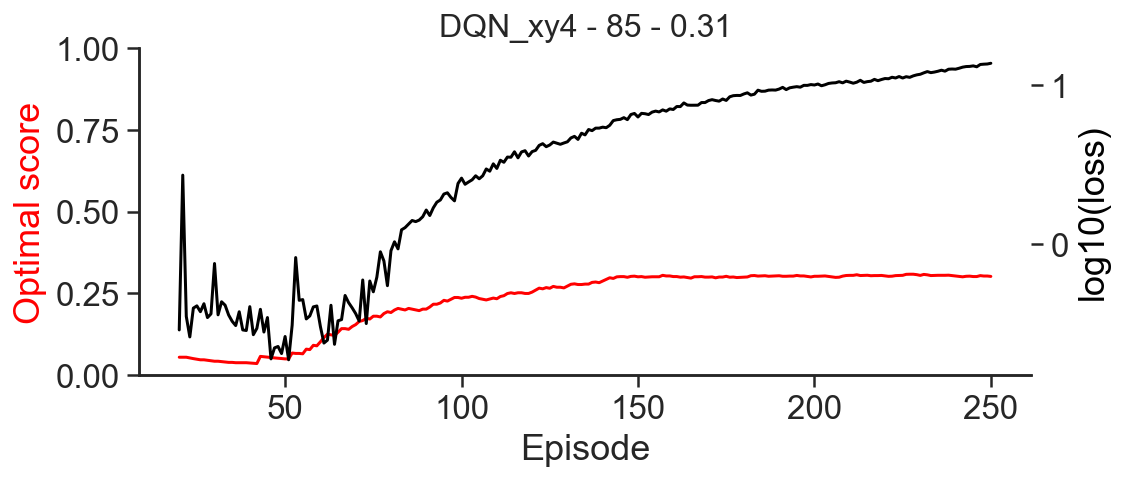

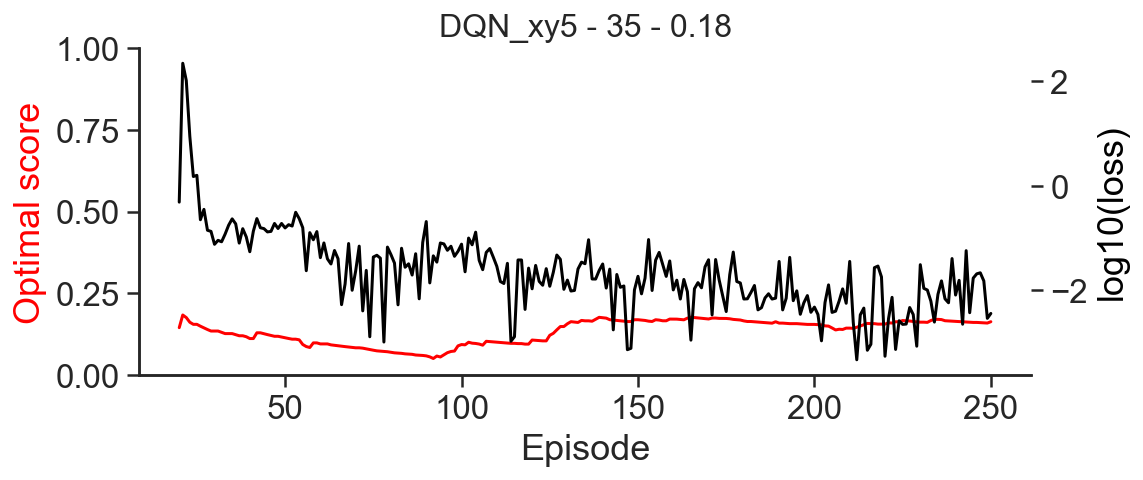

In [57]:
best_rows = [189, 25, 155, 85, 35] # score
# best_rows = [190, 246, 246, 172, 241] # loss

for row, model in zip(best_rows, models):
    data = load_data(path, model, run_index=index)
    fig, ax1 = plt.subplots(figsize=(8,3))
    mon = data[row]
    _ = ax1.plot(mon['episode'], mon['score'], color='red', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.max(mon['score']).round(2)}")
    _ = ax1.set_ylabel("Optimal score", color="red")
    _ = ax1.set_xlabel("Episode")
    _ = ax1.set_ylim(0, 1)
                  
    _ = ax2 = ax1.twinx()                      
    _ = ax2.plot(mon['episode'], np.log10(mon['loss']), color='black', alpha=1)
    _ = ax2.tick_params(axis='y')             
    _ = ax2.set_ylabel('log10(loss)', color="black")
    sns.despine()

# Find worst HP

For comparison. Make sure there is a strak difference.

In [45]:
for model in models:
    data = load_data(path, model, run_index=index)
    worst_hp = find_worst(hp, data, (200,250))
    print(f"{model}:\n{worst_hp}\n---")

DQN_xy1:
   row_code  device_code  epsilon  gamma  learning_rate
3         3            3      0.1    0.1       0.017653
---
DQN_xy2:
   row_code  device_code  epsilon  gamma  learning_rate
1         1            1      0.1    0.1       0.007551
---
DQN_xy3:
   row_code  device_code  epsilon  gamma  learning_rate
2         2            2      0.1    0.1       0.012602
---
DQN_xy4:
     row_code  device_code  epsilon  gamma  learning_rate
151       151            3      0.1    0.4       0.007551
---
DQN_xy5:
     row_code  device_code  epsilon  gamma  learning_rate
201       201            1      0.1    0.5       0.007551
---


## Plot worst

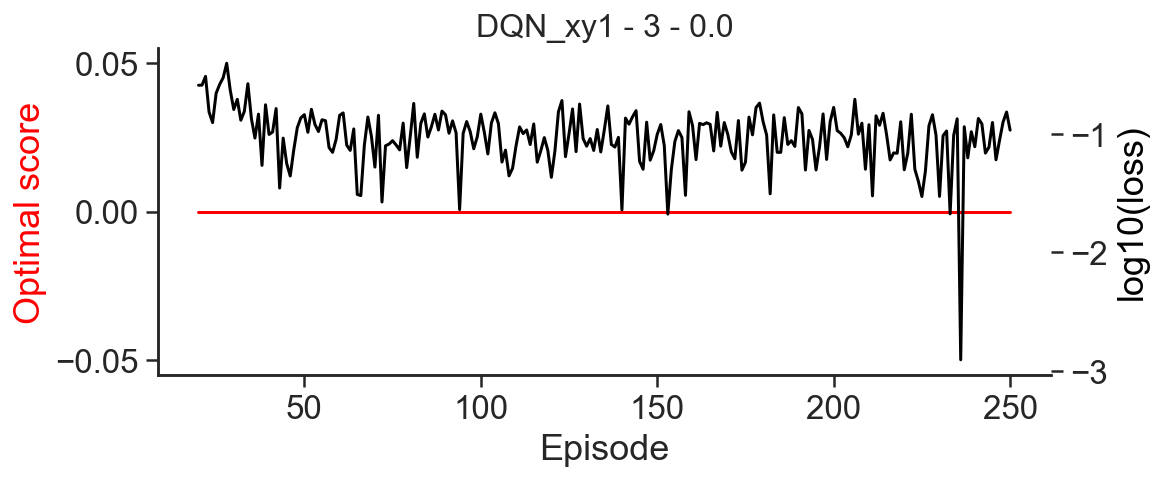

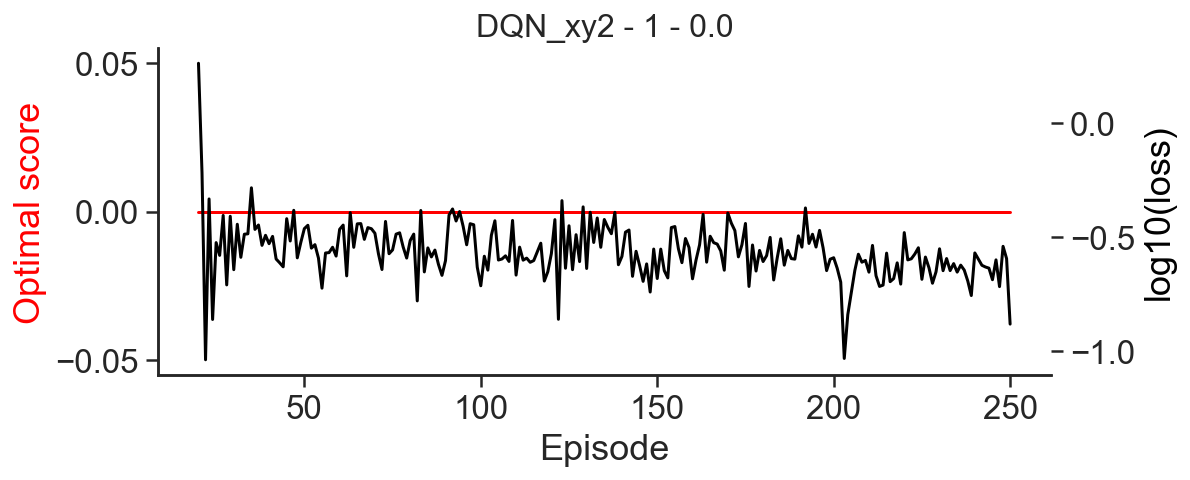

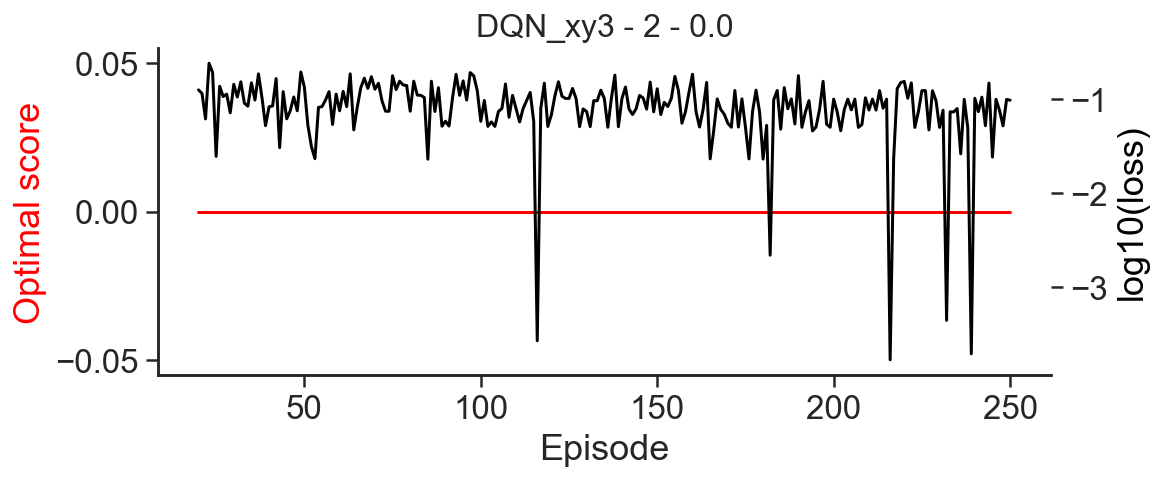

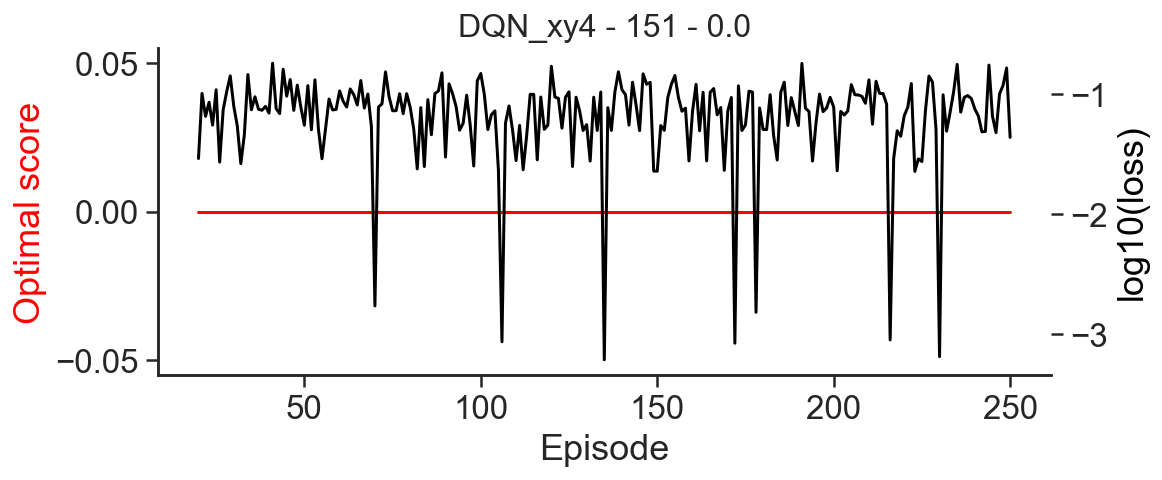

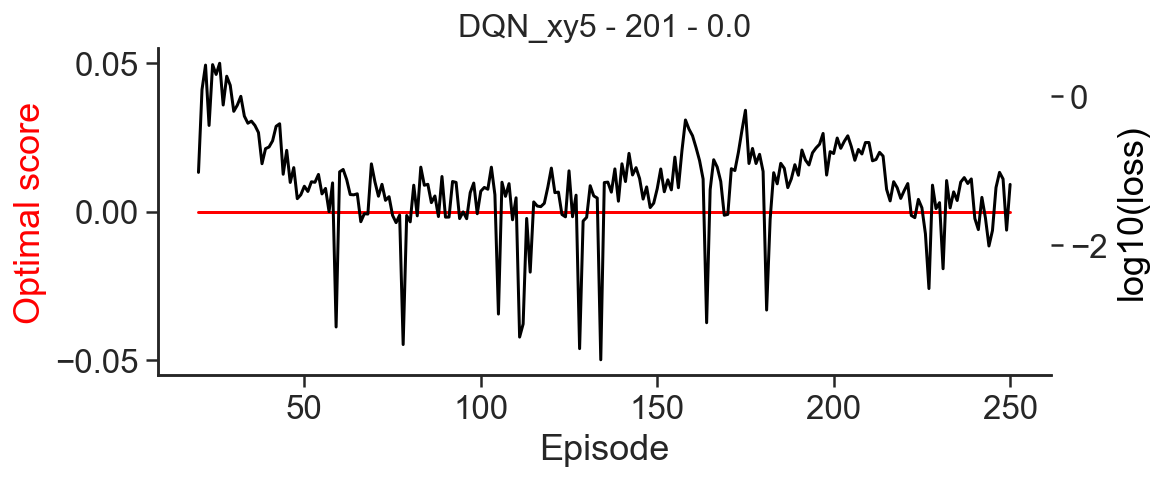

In [47]:
worst_rows = [3, 1, 2, 151, 201]

for row, model in zip(worst_rows, models):
    data = load_data(path, model, run_index=index)
    fig, ax1 = plt.subplots(figsize=(8,3))
    mon = data[row]
    _ = ax1.plot(mon['episode'], mon['score'], color='red', alpha=1)
    _ = plt.title(f"{model} - {row} - {np.max(mon['score']).round(2)}")
    _ = ax1.set_ylabel("Optimal score", color="red")
    _ = ax1.set_xlabel("Episode")
#     _ = ax1.ylim(0, 1)
                  
    _ = ax2 = ax1.twinx()                      
    _ = ax2.plot(mon['episode'], np.log10(mon['loss']), color='black', alpha=1)
    _ = ax2.tick_params(axis='y')             
    _ = ax2.set_ylabel('log10(loss)', color="black")
    sns.despine()